In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

## Loading and renaming data
def load_and_rename_data(filepath):
    """ Loads accelerometer data, detects the correct delimiter, and renames columns if necessary. """
    
    # Define column names
    column_names = ['time', 'x', 'y', 'z']
    
    # Automatically detect the delimiter
    with open(filepath, 'r') as file:
        first_line = file.readline()
    
    if ',' in first_line:
        sep = ','
    elif ';' in first_line:
        sep = ';'
    else:
        sep = '\s+'  # Multiple spaces
    
    # Load the data with the detected delimiter
    df = pd.read_csv(filepath, names=column_names, header=None, sep=sep, engine='python')

    print(f"Assigned columns with detected separator `{sep}` :", df.columns.tolist())

    # Convert the `time` column to datetime format
    df['time'] = pd.to_datetime(df['time'], errors='coerce')

    # Check for NaN values after conversion
    if df['time'].isna().sum() > 0:
        raise ValueError("Some values in the 'time' column could not be converted to datetime.")

    # Convert x, y, z columns to float
    df[['x', 'y', 'z']] = df[['x', 'y', 'z']].astype(float)

    return df

## Improved inactivity detection 
def detect_inactivity(data, window_size=10, std_threshold=0.013):
    """
    Detects inactivity periods using a method similar to GGIR.
    - Uses a **10-second window** (GGIR standard).
    - Based on the **standard deviation of accelerations**.
    - Excludes inactivity periods where values are close to zero (clipping).
    """
    rolling_std = data[['x', 'y', 'z']].rolling(window=window_size * 10, min_periods=1).std()
    
    # Exclude near-zero values (sensor clipping)
    no_movement = (
        (rolling_std['x'] < std_threshold) & 
        (rolling_std['y'] < std_threshold) & 
        (rolling_std['z'] < std_threshold) &
        (abs(data['x']) < 2) & (abs(data['y']) < 2) & (abs(data['z']) < 2)
    )
    
    return no_movement

## Cost function for calibration optimization
def calibration_cost(params, data):
    """ Cost function to minimize the error relative to 1g. """
    offsets = params[:3]
    gains = params[3:6]

    # Apply offset and gain correction
    corrected_data = (data - offsets) / gains
    norms = np.linalg.norm(corrected_data, axis=1)
    
    return norms - 1  # Returns deviation from 1g for each point

## Improved accelerometer calibration
def calibrate_accelerometer(data):
    """ Calibrates accelerometer data using a more robust optimization method (Least Squares). """
    inactive_periods = detect_inactivity(data)
    calibration_data = data[['x', 'y', 'z']][inactive_periods]

    # Ensure there are enough points for calibration
    if len(calibration_data) < 100:
        raise ValueError("Not enough inactivity points for proper calibration.")

    # Optimize offsets and gains using Least Squares
    initial_guess = [0, 0, 0, 1, 1, 1]  # [offset_x, offset_y, offset_z, gain_x, gain_y, gain_z]
    result = least_squares(calibration_cost, initial_guess, args=(calibration_data.to_numpy(),))

    optimized_offsets = result.x[:3]
    optimized_gains = result.x[3:6]

    # Apply calibration to the raw data
    data[['x', 'y', 'z']] = (data[['x', 'y', 'z']] - optimized_offsets) / optimized_gains

    print("Calibrated Offsets:", optimized_offsets)
    print("Calibrated Gains:", optimized_gains)

    return data, optimized_offsets, optimized_gains

## Save calibrated data
def save_calibrated_data(data, output_filepath):
    """ Saves the calibrated data to a CSV file. """
    data.to_csv(output_filepath, index=False)
    print(f"Calibrated data saved to: {output_filepath}")


# Script Execution 
input_filepath = "MG_D.csv"  # Replace with your raw data file
output_filepath = "calibrated_D.csv"  # Output file

data = load_and_rename_data(input_filepath)
calibrated_data, offsets, gains = calibrate_accelerometer(data)
save_calibrated_data(calibrated_data, output_filepath)


Assigned columns with detected separator `,` : ['time', 'x', 'y', 'z']
Calibrated Offsets: [-0.02797094 -0.02262415  0.00533957]
Calibrated Gains: [0.99407779 0.97636612 0.97031679]
Calibrated data saved to: calibrated_D.csv


In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import least_squares

## Sphere-Based Calibration Function
def sphere_fit_cost(params, data):
    """
    Cost function to fit a sphere around the accelerometer data.
    - params: [dx, dy, dz] (offsets for centering the data on the unit sphere)
    - data: Accelerometer data (inactivity periods)
    """
    dx, dy, dz = params  # Offsets to adjust the sphere's center

    # Apply the offsets to the data
    shifted_data = data - np.array([dx, dy, dz])

    # Compute the norm of each corrected point
    norms = np.linalg.norm(shifted_data, axis=1)

    # The error to minimize: deviation from 1g
    return norms - 1

## Calibration Function Using Sphere Fitting 
def calibrate_accelerometer_sphere(data):
    """ 
    Calibrates accelerometer data using sphere fitting.
    - Identifies inactivity periods.
    - Optimizes offsets to fit data to a 1g sphere.
    """
    # Detect inactivity periods (same method as before)
    inactive_periods = detect_inactivity(data)
    calibration_data = data[['x', 'y', 'z']][inactive_periods]

    # Ensure we have enough points for calibration
    if len(calibration_data) < 100:
        raise ValueError("Not enough inactivity points for proper calibration.")

    # Initial guess for offsets [dx, dy, dz] (start at 0)
    initial_guess = [0, 0, 0]

    # Optimize offsets using least squares
    result = least_squares(sphere_fit_cost, initial_guess, args=(calibration_data.to_numpy(),))

    optimized_offsets = result.x  # Optimized dx, dy, dz

    # Apply the calibration (adjust data to be centered around the sphere)
    data[['x', 'y', 'z']] = data[['x', 'y', 'z']] - optimized_offsets

    print("Calibrated Offsets (Sphere Fit):", optimized_offsets)

    return data, optimized_offsets

##  Save Calibrated Data 
def save_calibrated_data(data, output_filepath):
    """ Saves the calibrated data to a CSV file. """
    data.to_csv(output_filepath, index=False)
    print(f" Calibrated data saved to: {output_filepath}")

# Script Execution 

input_filepath = "MG_G.csv"  # Replace with your file
output_filepath = "calibrated_data_sphere.csv"

data = load_and_rename_data(input_filepath)
calibrated_data, offsets = calibrate_accelerometer_sphere(data)
save_calibrated_data(calibrated_data, output_filepath)


Assigned columns with detected separator `,` : ['time', 'x', 'y', 'z']
Calibrated Offsets (Sphere Fit): [-0.0293323  -0.04300886 -0.03093158]
 Calibrated data saved to: calibrated_data_sphere.csv


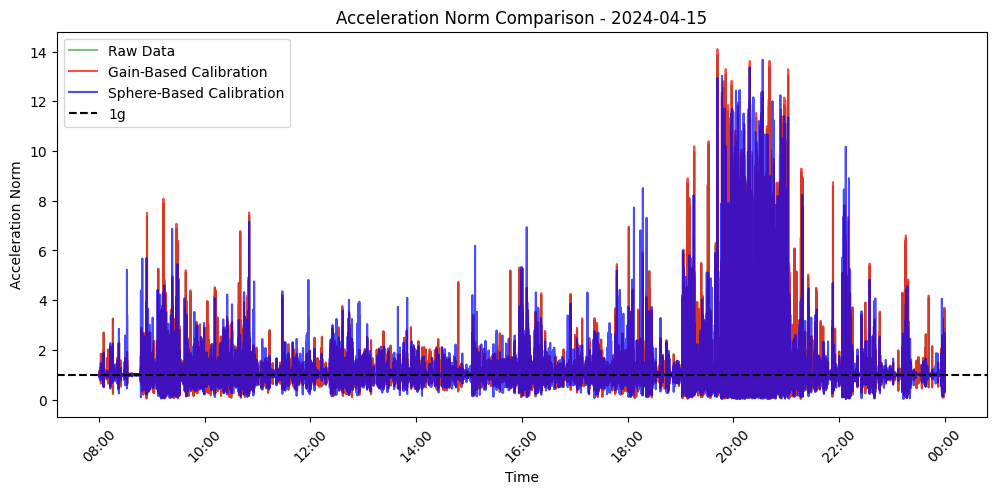

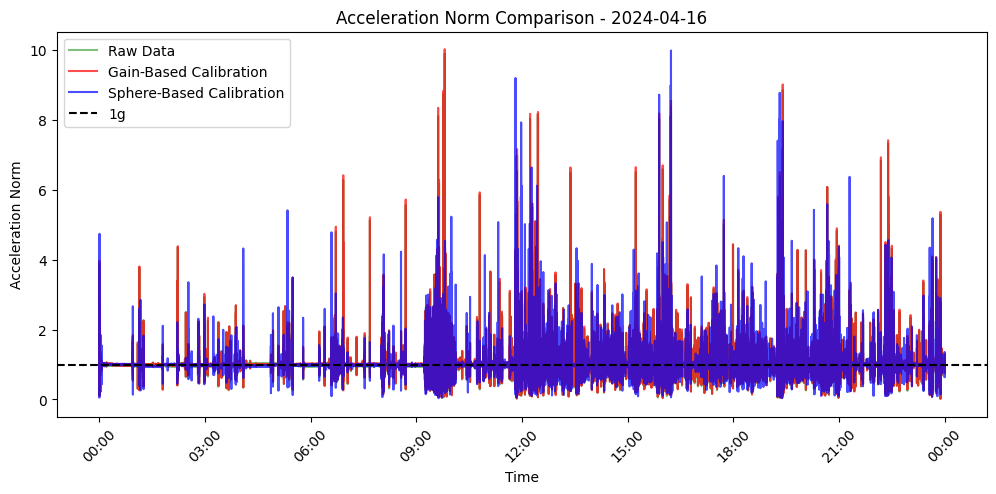

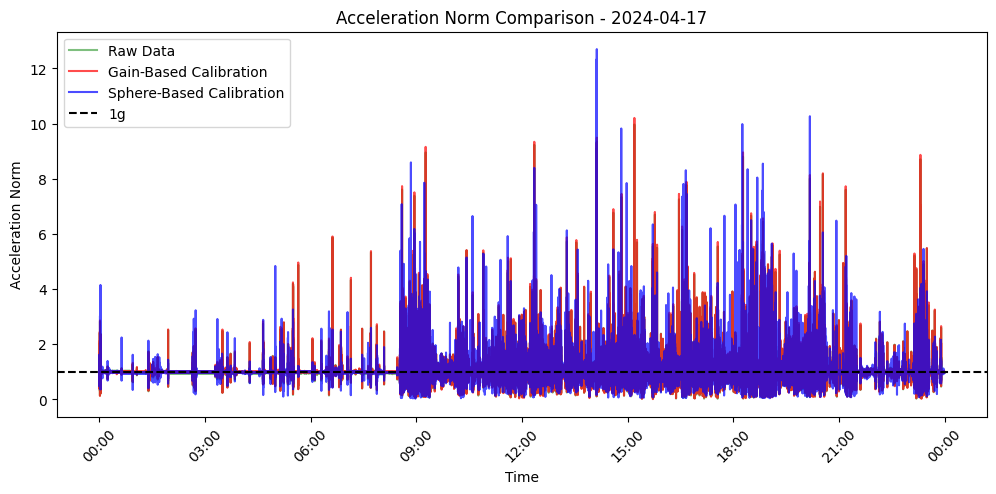

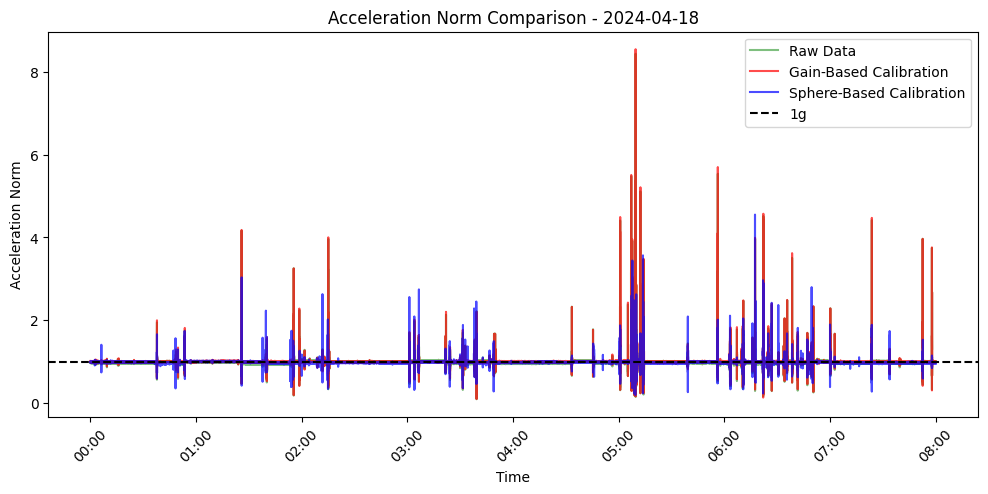

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

###  Load and Preprocess Data Safely
def load_and_prepare_data(filepath):
    """Loads accelerometer data, fixes missing headers, and ensures correct formatting."""
    df = pd.read_csv(filepath, header=None)  # No header in the file

    # Manually assign correct column names
    df.columns = ["time", "x", "y", "z"]  

    # Convert time column to datetime format
    df["time"] = pd.to_datetime(df["time"], errors="coerce")
    df["date"] = df["time"].dt.date  # Extract the date

    # Convert x, y, z to numeric values
    df[["x", "y", "z"]] = df[["x", "y", "z"]].apply(pd.to_numeric, errors='coerce')
    
    # Compute acceleration norm
    df["norm"] = np.linalg.norm(df[['x', 'y', 'z']], axis=1)
    
    return df

# Load the datasets safely
raw_data = load_and_prepare_data("MG_D.csv")
calibrated_gain = load_and_prepare_data("calibrated_D.csv")
calibrated_sphere = load_and_prepare_data("calibrated_data_sphere.csv")

## Visualize Data Day by Day
def plot_day_by_day(raw_data, calibrated_gain, calibrated_sphere):
    """Generates a time-series plot of acceleration norms per day."""
    unique_dates = raw_data["date"].unique()
    
    for date in unique_dates:
        plt.figure(figsize=(12, 5))
        
        # Filter data for the current day
        raw_day = raw_data[raw_data["date"] == date]
        gain_day = calibrated_gain[calibrated_gain["date"] == date]
        sphere_day = calibrated_sphere[calibrated_sphere["date"] == date]
        
        # Plot acceleration norms
        plt.plot(raw_day["time"], raw_day["norm"], label="Raw Data", color="green", alpha=0.5)
        plt.plot(gain_day["time"], gain_day["norm"], label="Gain-Based Calibration", color="red", alpha=0.7)
        plt.plot(sphere_day["time"], sphere_day["norm"], label="Sphere-Based Calibration", color="blue", alpha=0.7)

        plt.axhline(y=1, color='black', linestyle='--', label="1g")
        plt.xlabel("Time")
        plt.ylabel("Acceleration Norm")
        plt.title(f"Acceleration Norm Comparison - {date}")
        plt.legend()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        plt.xticks(rotation=45)
        plt.show()

# Run the visualization
plot_day_by_day(raw_data, calibrated_gain, calibrated_sphere)
